# Feature Selection

In [1]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from preprocessing import preprocess

sns.set()

In [2]:
# squash probabilities
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

## Load data

In [3]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

/home/bradley/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


## Split data

In [4]:
# Downsample, keep entries where player is rusher 
df = df[df['NflIdRusher']==df['NflId']]
df.reset_index(drop=True, inplace=True)

train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)
print(train.shape)
print(dev.shape)

(16219, 49)
(6952, 49)


 # PreProcess

In [5]:
train, tables = preprocess(train)
dev, tables = preprocess(dev, tables)
train.head()
dev.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,WindSpeed,WindDirection,DefenseTeam,YardsAvgOffense,YardsAvgDefense,YardsRemaining,Carries,RusherMeanYards,RusherMaxYards,RusherMinYards
0,2017111907,20171119070499,home,30.27,28.56,3.74,1.71,0.41,14.29,113.39,...,6,W,BUF,4.443203,4.426667,75.0,329.0,4.322188,87.0,-4.0
1,2017102906,20171029063422,home,27.79,33.27,5.46,0.33,0.51,222.48,325.48,...,12,SE,SF,4.335185,4.058099,12.0,222.0,3.815315,68.0,-7.0
2,2018112503,20181125031651,away,30.70,22.33,4.64,2.94,0.45,272.10,251.62,...,4,S,CIN,4.452747,4.315881,16.0,134.0,5.537313,92.0,-5.0
3,2018101412,20181014120662,home,19.15,28.65,4.19,1.99,0.41,256.20,249.31,...,Calm,NaN,KC,4.500000,4.602210,4.0,149.0,4.382550,31.0,-4.0
4,2018112509,20181125090940,away,47.84,25.86,4.71,3.29,0.46,265.69,285.56,...,7,North,DEN,4.261224,4.001908,33.0,179.0,4.653631,30.0,-4.0


# Fit Models

In [6]:
# Let's do MLE for comparison 
# calculate pmf 
yard_counts = np.zeros((199), dtype = 'double')
for yard in range(-99, 100):
    yard_counts[yard+99] = sum(train['Yards']==yard)
yard_probabilities = yard_counts / np.sum(yard_counts)

# calculate cdf
mle_cdf = np.cumsum(yard_probabilities)

In [7]:
# Model Fitting 
# create a label encoder since not all -99:99 yards will appear 
features = ['Distance','Down','DefendersInTheBox','A']

le = preprocessing.LabelEncoder()
le.fit(train['Yards'])

# Fit the model  
# clf = LogisticRegression(C = .2, max_iter = 100,solver = 'newton-cg',multi_class='multinomial',verbose=True)
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, min_samples_split=20, min_samples_leaf=10)

clf.fit(train[features], le.transform(train['Yards']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# Calculate Loss

In [8]:
def predsToPMF(preds):
    pmfs = np.zeros((preds.shape[0],199))
    for i in range(0, preds.shape[1]):
        pmfs[:,int(le.inverse_transform([i]))+99] = preds[:,i]
    return pmfs 

# predict on dev set and convert to pmf -> cdf 
preds = clf.predict_proba(dev[features])
preds_pmfs = predsToPMF(preds)
preds_cdfs = np.cumsum(preds_pmfs, axis=1)

all_loss = []
all_loss_mle = [] 
i = 0
for index, row in dev.iterrows():
    # squash cdfs 
    preds_cdfs[i,:] = squash(preds_cdfs[i,:], int(row['YardsRemaining']))
    mle_cdf_squash = squash(mle_cdf, int(row['YardsRemaining']))
    
    # ground truth 
    true_cdf = np.zeros(199)
    true_cdf[99+row['Yards']:] = 1
    
    # loss
    loss = 1/199 * np.sum((preds_cdfs[i,:]-true_cdf)**2)
    loss_mle = 1/199 * np.sum((mle_cdf_squash-true_cdf)**2)
    all_loss.append(loss)
    all_loss_mle.append(loss_mle)
    
    i += 1 
# cost
cost = np.average(all_loss)
cost_mle = np.average(all_loss_mle)

print("Cost: {}".format(cost))
print("MLE Cost: {}".format(cost_mle))

Cost: 0.013611953065554799
MLE Cost: 0.014036657158360893


# Feature Selection

In [9]:
def predsToPMF(preds):
    pmfs = np.zeros((preds.shape[0],199))
    for i in range(0, preds.shape[1]):
        pmfs[:,int(le.inverse_transform([i]))+99] = preds[:,i]
    return pmfs 

def calculate_cost(preds_cdf):
    all_loss = []
    i = 0
    for index, row in dev.iterrows():
        preds_cdfs[i,:] = squash(preds_cdfs[i,:], int(row['YardsRemaining']))
        true_cdf = np.zeros(199)
        true_cdf[99+row['Yards']:] = 1
        loss = 1/199 * np.sum((preds_cdfs[i,:]-true_cdf)**2)
        all_loss.append(loss)
        i += 1 
    cost = np.average(all_loss)
    return cost
    
def squash(yard_cdf, yard_remaining):
    squash_cdf = yard_cdf.copy()
    squash_cdf[199-(100 - yard_remaining):] = 1
    squash_cdf[0:yard_remaining-1] = 0 
    return squash_cdf

In [25]:
#Try manual forward selection.
features_of_interest_all = ['Distance','Down','DefendersInTheBox','RusherMeanYards', 'A', 'YardsRemaining', 'Carries']
le = preprocessing.LabelEncoder()
le.fit(train['Yards'])
y_train = le.transform(train['Yards'])
selected_features = []
clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, min_samples_split=20, min_samples_leaf=10)

#specifies how many features we want to add
costs = []
nums_to_add = [1, 2, 3, 4, 5]
for num_to_add in nums_to_add:
    num_added = 0
    features_of_interest = features_of_interest_all.copy()
    selected_features = [] 
    while num_added < num_to_add and len(features_of_interest) > 0:
        current_cost = float('inf')
        for i in range (0, len(features_of_interest)):
            #fit a model for each feature, then pair of features, etc
            feature = features_of_interest[i]
            clf.fit(train[selected_features + [feature]], y_train)
            preds = clf.predict_proba(dev[selected_features + [feature]])
            preds_pmfs = predsToPMF(preds)
            preds_cdfs = np.cumsum(preds_pmfs, axis=1)
            #predict cost of the model after adding the new feature
            cost = calculate_cost(preds_cdfs)
            if cost < current_cost:
                current_cost = cost
                selected_feature = feature
            if i == len(features_of_interest) - 1:
                selected_features.append(selected_feature)
                features_of_interest.remove(selected_feature)
        num_added += 1
    print("With {}, we use {}.".format(num_to_add, selected_features))
    costs.append(current_cost)

With 1, we use ['A'].
With 2, we use ['A', 'DefendersInTheBox'].
With 3, we use ['A', 'DefendersInTheBox', 'Distance'].
With 4, we use ['A', 'DefendersInTheBox', 'Distance', 'Carries'].
With 5, we use ['A', 'DefendersInTheBox', 'Distance', 'Carries', 'Down'].


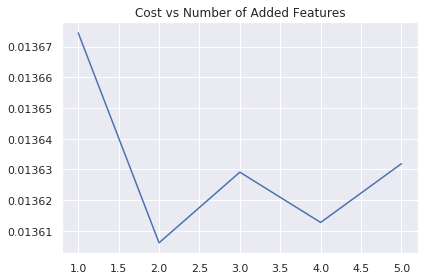

In [26]:
plt.plot(nums_to_add, costs)
plt.title('Cost vs Number of Added Features')
plt.tight_layout()